# Wasserstein GAN

_hip_, _cool_ and ✨stable🌟 _generative adversarial network_. Based on a [paper by arjovsky, et al](https://arxiv.org/abs/1701.07875).


In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi
import os
from tensorflow.contrib.layers.python.layers import batch_norm
from tensorflow.contrib.layers import xavier_initializer
from PIL import Image
import urllib, cStringIO
import cv2


In [2]:
BATCH_SIZE = 32


In [3]:
from read_mnist import read_images, read_labels
def load_dataset(name):
    def featurize(image):
        return image.astype(float) / 255.0
    images = np.array([featurize(image) for image in read_images(name + '-images-idx3-ubyte')])
    labels = np.array([label for label in read_labels(name + '-labels-idx1-ubyte')])
    return images, labels
test_in, test_out = load_dataset('../data/t10k')
train_in, train_out = load_dataset('../data/train')

In [4]:
print test_in[0].shape

(28, 28)


In [5]:
# filename_queue = tf.train.string_input_producer(image_names, num_epochs=None)
# attr_queue = tf.train.input_producer(tf.constant(attr_vector), num_epochs=None)

def create_q():
    image_tensor = tf.convert_to_tensor(test_in, dtype=tf.float32)
    image_q = tf.train.slice_input_producer([image_tensor], num_epochs=None, shuffle=True)[0]
    images_batch = tf.train.shuffle_batch([image_q], batch_size=BATCH_SIZE, capacity=BATCH_SIZE*20, min_after_dequeue=BATCH_SIZE*10)
    return images_batch

images_batch = create_q()


In [6]:
session = tf.InteractiveSession()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)
tf.train.start_queue_runners(sess=session)

[<Thread(Thread-13, started daemon 140706716010240)>,
 <Thread(Thread-14, started daemon 140706707617536)>]

(32, 28, 28)


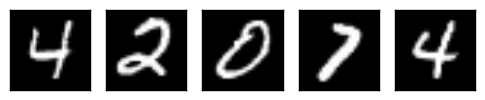

In [7]:
%matplotlib inline

images_ = session.run(images_batch)
print images_.shape

imshow_multi(images_[:5])

In [8]:
def lrelu(x):
    alpha = 0.05
    return tf.maximum(alpha*x, x)

def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    axis = len(x.get_shape())-1
    return tf.nn.elu(tf.concat(axis, [x, -x]))

def concat_lrelu(x):
    axis = len(x.get_shape())-1
    return lrelu(tf.concat(axis, [x, -x]))

def concat_relu(x):
    axis = len(x.get_shape())-1
    return tf.nn.relu(tf.concat(axis, [x, -x]))

def create_batch_norm(inputs, name='bn'):
    with tf.variable_scope(name):
        return batch_norm(inputs, is_training=True, updates_collections=None, decay=0.9)

conv_init = tf.truncated_normal_initializer(0, 0.1)
bias_init = tf.truncated_normal_initializer(0.1, 0.0)

def create_max_pool(inputs, ksize=2, stride=2):
    return tf.nn.max_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_avg_pool(inputs, ksize=2, stride=2):
    return tf.nn.avg_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_conv(input, out_channels, patch_size=5, stride=1, name='conv'):
    with tf.variable_scope(name):
        in_channels = input.get_shape()[-1].value
        # w = weight_var([patch_size, patch_size, in_channels, out_channels], name='w', key=join_keys(key, 'w'))
        # b = weight_var([out_channels], stddev=0, name='b', mean=0.1, key=join_keys(key, 'b'))
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, in_channels, out_channels], 
                            initializer=conv_init)
        b = tf.get_variable('b',
                           shape=[out_channels],
                           initializer=bias_init)
        conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
        return conv+b

def create_deconv(input, out_channels, patch_size=5, stride=1, name='deconv'):
    with tf.variable_scope(name):
        # for best results, patch_size should be a multiple of stride
        input_w, input_h, input_channels = [i.value for i in input.get_shape()[-3:]]

        # w = weight_var([patch_size, patch_size, out_channels, input_channels])
        # b = weight_var([out_channels], mean=0.1)
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, out_channels, input_channels], 
                            initializer=conv_init)
        b = tf.get_variable('b',
                            shape=[out_channels],
                            initializer=bias_init)

        batch_size = BATCH_SIZE # tf.shape(input)[0]
        output_shape = tf.pack([batch_size, input_w*stride, input_h*stride, out_channels])

        deconv = tf.nn.conv2d_transpose(input, w, output_shape, strides=[1,stride,stride,1], padding='SAME')

        return deconv + b

def create_fc(input, out_channels, name='fc'):
    with tf.variable_scope(name):
        in_channels = input.get_shape()[-1].value
        w = tf.get_variable('w', shape=[in_channels, out_channels], initializer=conv_init)
        b = tf.get_variable('b', shape=[out_channels], initializer=bias_init)
        return tf.matmul(input, w) + b


In [9]:
def generator(noise_vec, name='gen', reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        vec = tf.nn.relu(create_fc(noise_vec, 256, name='fc1'))
        image = tf.reshape(vec, [-1, 4, 4, 16])
        layers = [32, 32, 32]
        for i, channels in enumerate(layers):
                image = create_deconv(image, channels, patch_size=4, stride=2, name='deconv'+str(i))
                image = lrelu(image)
                image = create_batch_norm(image, name='bn'+str(i))
        image = create_conv(image, 1, 1, 1, name='color_conv')
        image = tf.nn.tanh(image)
        return image

def critic(image, name='critic', reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        layers = [32, 32, 32]
        for i, channels in enumerate(layers):
            image = create_conv(image, channels, patch_size=5, stride=1, name='conv'+str(i))
            image = lrelu(image)
            image = create_batch_norm(image, name='bn'+str(i))
            image = create_avg_pool(image)
        vec = tf.reshape(image, [-1, 4 * 4 * 32])
        vec = lrelu(create_fc(vec, 128, name='fc0'))
        is_real = create_fc(vec, 1, name='fc_is_real')
        return tf.reshape(is_real, [-1])

scopename = 'wgan2'
with tf.variable_scope(scopename, reuse=False):
    gen_lr = tf.placeholder_with_default(tf.constant(5e-4), [], name='gen_lr')
    critic_lr = tf.placeholder_with_default(tf.constant(5e-4), [], name='critic_lr')
    
    images_resized = tf.image.resize_bilinear(tf.reshape(images_batch, [-1, 28, 28, 1]), [32, 32])
    
    noise = tf.random_uniform([BATCH_SIZE, 32], minval=-1, maxval=1)
    generated_images = generator(noise)
    
    are_fakes_real = critic(generated_images)
    are_reals_real = critic(images_resized, reuse=True)
    
    gen_loss = -tf.reduce_mean(are_fakes_real)
    critic_loss = tf.reduce_mean(are_fakes_real - are_reals_real)
        
    # only increment the global step when training the generator:
    global_step = tf.contrib.framework.get_or_create_global_step()
    
    critic_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/critic')
    weight_clip_op = tf.group(*[w.assign(tf.clip_by_value(w, -0.01, 0.01)) for w in critic_vars])
    train_critic_op = tf.train.RMSPropOptimizer(critic_lr).minimize(critic_loss, var_list=critic_vars)
    train_critic = tf.group(weight_clip_op, train_critic_op)
    
    gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/gen')
    train_gen = tf.train.AdamOptimizer(gen_lr).minimize(gen_loss, global_step=global_step, var_list=gen_vars)
    
    examples = generated_images


In [10]:
session = None
saver = None
save_path = None

def create_session():
    global session
    global saver
    global save_path
    
    if session: session.close()
    
    session = tf.InteractiveSession()

    save_path = 'models/mnist-wgan-1'
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    session.run(init_op)
    tf.train.start_queue_runners(sess=session)

    import os
    saver = None
    if save_path:
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(save_path)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(session, ckpt.model_checkpoint_path)
            print 'Restored from checkpoint', ckpt.model_checkpoint_path
        else:
            print 'Did not restore from checkpoint'
    else:
        print 'Will not save progress'

create_session()

Restored from checkpoint models/mnist-wgan-1/model.ckpt-7500


Step: 7760, critic loss: -0.830647754669


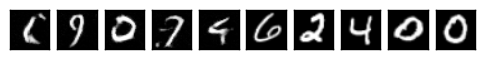

Step: 7780, critic loss: -0.927338104732


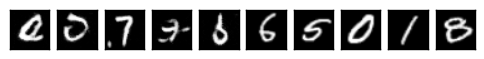

Step: 7800, critic loss: -0.915914347693


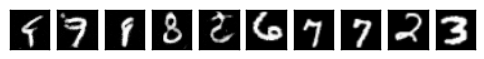

Step: 7820, critic loss: -1.05488935262


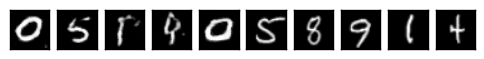

Step: 7840, critic loss: -1.15690766692


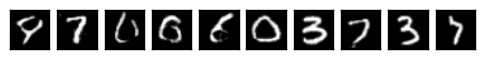

KeyboardInterrupt: 

In [12]:
%matplotlib inline

def avg(x): return sum(x) / float(len(x))

savecount = 0

last_step_printed = -1

losses = []

while True:
    examples_ = None
    step_ = global_step.eval()
    
    for _ in xrange(50 if step_ < 25 or step_ % 500 == 0 else 5):
        critic_loss_, _ = session.run([critic_loss, train_critic])
        losses.append(critic_loss_)
    
    session.run(train_gen)
    
    if step_ % 20 == 0:
        print "Step: {}, critic loss: {}".format(step_, avg(losses))
        losses = []
            
        examples_ = session.run(tf.reshape(examples[:5], [5, 32, 32]))
        reals_ = session.run(tf.reshape(images_resized[:5], [5, 32, 32]))
        
        if step_ % 20 == 0:
            imshow_multi(list(examples_) + list(reals_))
        
        if step_ % 500 == 0 and saver:
            should_save = True
            if should_save:
                saver.save(session, save_path + '/model.ckpt', global_step=step_)
                print 'Saved'
                savecount += 1
                if savecount > 4:
                    create_session()
                    savecount = 0


In [ ]:
# debug:

fake_cond_vec_, real_cond_vec_, _ = session.run([fake_cond_vec, real_cond_vec, images_batch])
print fake_cond_vec_
print real_cond_vec_

In [ ]:
%matplotlib inline

examples_ = session.run(examples[:5])
imshow_multi(list(examples_))
